In [1]:
import os 
import pandas as pd
import numpy as np
import pynapple as nap
os.chdir(r'Q:\sachuriga\Sachuriga_Python/quattrocolo-nwb4fp\src')
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,Speed_filtered_spikes, find_run_indices
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap_ax,plot_path
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.tools import masked_corrcoef2d,nancorrelate2d,fftcorrelate2d
from nwb4fp.analyses.border_scores import border_score
from nwb4fp.analyses.functional_scores import prob_dist,information_specificity,information_rate,sparsity,map_stats_pdf,shuffule_spi
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings


In [ ]:
## file loadings
import pandas as pd
from turtle import color
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

df_loaded = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements.pkl')
base_folser = r"S:\Sachuriga\nwb\test4neo"
#temp_nwb = pd.read_pickle(fr"S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py/63383_2024-07-25_A_units_table_withDLC.pkl")
nwb_files = np.unique(df_loaded["session_id"])
all_tabbles = []

for i in range(len(nwb_files)):
    df_temp = df_loaded[df_loaded['session_id']==nwb_files[i]]
    npdata = nap.load_file(fr"{base_folser}/{nwb_files[i]}")
    position_cord = load_speed_fromNWB(npdata['XY_mid_brain'])
    raw_pos,combined_array, mask,speeds,smoothed_speed,filtered_speed = pos2speed(position_cord[:,0], # times
                                position_cord[:,1], # x
                                position_cord[:,2], # y
                                filter_speed=True, 
                                min_speed = 0.05)
    time_stemp = position_cord[:,0]
    starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
    run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
    positions = nap.TsdFrame(t=position_cord[:,0], d=position_cord[:,1:3], columns=['X', 'Y'])
    speed_filtered = positions.restrict(run_ep).as_dataframe()
    df_temp['Information_rate'] = None
    df_temp['Information_content_rate'] = None
    df_temp['Sparsity'] = None
    df_temp['Selectivity'] = None
    df_temp['Averate_rate'] = None
    df_temp['Information_rate_shuffle'] = None
    df_temp['Information_content_rate_shuffle'] = None
    df_temp['Sparsity_shuffle'] = None
    df_temp['Selectivity_shuffle'] = None
    df_temp['Fields_number'] = None
    df_temp['Field_size'] = None
    df_temp['Boarder_score'] = None
    df_temp['Coherence'] = None
    #df_temp['stability_nan'] = None
    df_temp['stability_ma']= None
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    for i in tqdm(range(len(df_temp)), desc="Processing rows"):  
        row = df_temp.iloc[[i]]
        spikes_time = list(row['spike_times'].values[0])
        temp = nap.Ts(spikes_time, time_units='s')
        spikes_time_speed_filtered = temp.restrict(run_ep)
        maps1 = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0)
        rate_map1 = maps1.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())

        t = speed_filtered.index.values
        x = speed_filtered['X'].values
        y = speed_filtered['Y'].values
        s = spikes_time_speed_filtered.times()

        # Get the midpoint time value
        midpoint = (t[0] + t[-1]) / 2

        # Split t, x, y into first and second halves
        mask_first_half = t < midpoint
        mask_second_half = t >= midpoint

        t_first_half = t[mask_first_half]
        x_first_half = x[mask_first_half]
        y_first_half = y[mask_first_half]

        t_second_half = t[mask_second_half]
        x_second_half = x[mask_second_half]
        y_second_half = y[mask_second_half]

        # Split spikes times s using the same midpoint value
        s_first_half = s[s < midpoint]
        s_second_half = s[s >= midpoint]

        maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.05)
        rate_map_first_half = maps.rate_map(x_first_half, y_first_half, t_first_half, s_first_half)
        rate_second_half = maps.rate_map(x_second_half, y_second_half, t_second_half, s_second_half)



        #df_temp['stability_nan'].iloc[[i]] = nancorrelate2d(rate_map_first_half, rate_second_half, mode="pearson")
        df_temp['stability_ma'].iloc[[i]] = masked_corrcoef2d(rate_map_first_half, rate_second_half).data[0][1]

        df_temp['Coherence'].iloc[i] = coherence(rate_map1, normalize='on')
        
        rate_map = maps.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())
        fields = separate_fields_by_dilation(rate_map, 
                                        minimum_field_area=9)
        fiesld_afremoval_array = remove_fields_by_area(fields, minimum_field_area=9)
        fiesld_afremoval=fiesld_afremoval_array.flatten()
        fileds_num = len(np.unique(fiesld_afremoval.flatten()))-1
        fileds_size = len(fiesld_afremoval[np.where(fiesld_afremoval==1)])/len(fiesld_afremoval) * 100
        df_temp['Fields_number'].iloc[i] = fileds_num
        df_temp['Field_size'].iloc[i] = fileds_size
        occupancy_map = maps.occupancy_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, mask_zero_occupancy=False)
        px = occupancy_map/np.sum(occupancy_map)
        df_temp['Information_rate'].iloc[[i]] = map_stats_pdf(rate_map,px)[0]['rate']
        df_temp['Information_content_rate'].iloc[[i]] = map_stats_pdf(rate_map,px)[0]['content']
        df_temp['Averate_rate'].iloc[[i]]=map_stats_pdf(rate_map,px)[3]
        df_temp['Sparsity'].iloc[[i]] = map_stats_pdf(rate_map,px)[1]
        df_temp['Selectivity'].iloc[[i]] = map_stats_pdf(rate_map,px)[2]
        df_temp['Boarder_score'].iloc[[i]] = border_score(rate_map, fiesld_afremoval_array)
        result_info_rate, result_content_rate, result_sparsity_rate, result_selectivity_rate = shuffule_spi_test(list(speed_filtered['X'].values),
                                                                                                        list(speed_filtered['Y'].values),
                                                                                                        list(speed_filtered.index.values), 
                                                                                                        list(spikes_time_speed_filtered.times()), 
                                                                                                        1000)
        df_temp['Information_rate_shuffle'].iloc[i] = result_info_rate
        df_temp['Information_content_rate_shuffle'].iloc[i] = result_content_rate
        df_temp['Sparsity_shuffle'].iloc[i] = result_sparsity_rate
        df_temp['Selectivity_shuffle'].iloc[i] = result_selectivity_rate
    all_tabbles.append(df_temp)
final_df = pd.concat(all_tabbles, ignore_index=True)
final_df['h_0_place_cell']=None

for i in range(len(final_df)):
    quantile_975 = np.nanpercentile(np.array(final_df['Information_content_rate_shuffle'].iloc[i][:]), 95)
    if final_df['Information_content_rate'].iloc[i] > quantile_975:
        final_df['h_0_place_cell'].iloc[i]=1
    else:
        final_df['h_0_place_cell'].iloc[i]=0
        
# Optional: Save to file
final_df.to_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements_with_stability.pkl')

Processing rows:  64%|██████▍   | 9/14 [04:29<02:29, 29.90s/it]


KeyboardInterrupt: 

In [6]:
## file loadings
import pandas as pd
from turtle import color
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

df_loaded = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements.pkl')
base_folser = r"S:\Sachuriga\nwb\test4neo"
#temp_nwb = pd.read_pickle(fr"S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py/63383_2024-07-25_A_units_table_withDLC.pkl")
nwb_files = np.unique(df_loaded["session_id"])
all_tabbles = []

for i in range(len(nwb_files)):
    df_temp = df_loaded[df_loaded['session_id']==nwb_files[i]]
    npdata = nap.load_file(fr"{base_folser}/{nwb_files[i]}")
    position_cord = load_speed_fromNWB(npdata['XY_mid_brain'])
    raw_pos,combined_array, mask,speeds,smoothed_speed,filtered_speed = pos2speed(position_cord[:,0], # times
                                position_cord[:,1], # x
                                position_cord[:,2], # y
                                filter_speed=True, 
                                min_speed = 0.05)
    time_stemp = position_cord[:,0]
    starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
    run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
    positions = nap.TsdFrame(t=position_cord[:,0], d=position_cord[:,1:3], columns=['X', 'Y'])
    speed_filtered = positions.restrict(run_ep).as_dataframe()

    df_temp['stability_ma']= None
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    for i in tqdm(range(len(df_temp)), desc="Processing rows"):  
        row = df_temp.iloc[[i]]
        spikes_time = list(row['spike_times'].values[0])
        temp = nap.Ts(spikes_time, time_units='s')
        spikes_time_speed_filtered = temp.restrict(run_ep)
        maps1 = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0)
        rate_map1 = maps1.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())

        t = speed_filtered.index.values
        x = speed_filtered['X'].values
        y = speed_filtered['Y'].values
        s = spikes_time_speed_filtered.times()

        # Get the midpoint time value
        midpoint = (t[0] + t[-1]) / 2

        # Split t, x, y into first and second halves
        mask_first_half = t < midpoint
        mask_second_half = t >= midpoint

        t_first_half = t[mask_first_half]
        x_first_half = x[mask_first_half]
        y_first_half = y[mask_first_half]

        t_second_half = t[mask_second_half]
        x_second_half = x[mask_second_half]
        y_second_half = y[mask_second_half]

        # Split spikes times s using the same midpoint value
        s_first_half = s[s < midpoint]
        s_second_half = s[s >= midpoint]

        maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.1)
        rate_map_first_half = maps.rate_map(x_first_half, y_first_half, t_first_half, s_first_half)
        rate_second_half = maps.rate_map(x_second_half, y_second_half, t_second_half, s_second_half)
        #df_temp['stability_nan'].iloc[[i]] = nancorrelate2d(rate_map_first_half, rate_second_half, mode="pearson")
        df_temp['stability_ma'].iloc[[i]] = masked_corrcoef2d(rate_map_first_half, rate_second_half).data[0][1]

    all_tabbles.append(df_temp)
final_df = pd.concat(all_tabbles, ignore_index=True)

        
# Optional: Save to file
final_df.to_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements_with_stability.pkl')

Processing rows:   0%|          | 0/13 [00:00<?, ?it/s]Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\maps.py:154: RuntimeWarning: invalid value encountered in divide
  rate_map = spike_map / occupancy_map
Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\maps.py:154: RuntimeWarning: invalid value encountered in divide
  rate_map = spike_map / occupancy_map
Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\maps.py:154: RuntimeWarning: invalid value encountered in divide
  rate_map = spike_map / occupancy_map
Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\maps.py:154: RuntimeWarning: invalid value encountered in divide
  rate_map = spike_map / occupancy_map
Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\maps.py:154: RuntimeWarning: invalid value encountered in divide
  rate_map = spike_map / occupancy_map
Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\maps.py:154

In [95]:

control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

session_A = final_df[(final_df['session']=='A') & (final_df['cell_type']=='pyramidal')]

control_df = session_A [session_A ['animal_id'].isin(control_ids)]
mean_shuffle = []
all_shuffle = []
for i in range(len(control_df)):
    temp = control_df['Information_content_rate_shuffle'].iloc[i]
    mean_shuffle.append(np.median(temp))
    for n in temp:
        all_shuffle.append(n)

In [102]:
np.nanquantile(control_df['mean_firing_rate'].values, 0.975)
#plt.hist(control_df['Averate_rate'].values)

5.011437274400125

In [74]:
file = '63383_2024-07-30_12-33-52_A_phy_k_manual.nwb'

df_temp = df_loaded[df_loaded['session_id']==file]
npdata = nap.load_file(fr"{base_folser}/{file}")
position_cord = load_speed_fromNWB(npdata['XY_mid_brain'])
raw_pos,combined_array, mask,speeds,smoothed_speed,filtered_speed = pos2speed(position_cord[:,0], # times
                            position_cord[:,1], # x
                            position_cord[:,2], # y
                            filter_speed=True, 
                            min_speed = 0.05)

time_stemp = position_cord[:,0]
starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
positions = nap.TsdFrame(t=position_cord[:,0], d=position_cord[:,1:3], columns=['X', 'Y'])
speed_filtered = positions.restrict(run_ep).as_dataframe()

df_temp['Information_rate'] = None
df_temp['Information_content_rate'] = None
df_temp['Sparsity'] = None
df_temp['Selectivity'] = None
df_temp['Averate_rate'] = None
df_temp['Information_rate_shuffle'] = None
df_temp['Information_content_rate_shuffle'] = None
df_temp['Sparsity_shuffle'] = None
df_temp['Selectivity_shuffle'] = None
df_temp['Fields_number'] = None
df_temp['Field_size'] = None
df_temp['Boarder_score'] = None
df_temp['Coherence'] = None


warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
for i in tqdm(range(len(df_temp)), desc="Processing rows"):
    
    row = df_temp.iloc[[i]]
    spikes_time = list(row['spike_times'].values[0])
    temp = nap.Ts(spikes_time, time_units='s')
    spikes_time_speed_filtered = temp.restrict(run_ep)
    maps1 = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0)
    rate_map1 = maps1.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())
    df_temp['Coherence'].iloc[i] = coherence(rate_map1, normalize='on')

    maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.05)
    rate_map = maps.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())
    fields = separate_fields_by_laplace(rate_map, 
                                    minimum_field_area=9)
    fiesld_afremoval_array = remove_fields_by_area(fields, minimum_field_area=9)
    fiesld_afremoval=fiesld_afremoval_array.flatten()
    fileds_num = len(np.unique(fiesld_afremoval.flatten()))-1
    fileds_size = len(fiesld_afremoval[np.where(fiesld_afremoval==1)])/len(fiesld_afremoval) * 100
    df_temp['Fields_number'].iloc[i] = fileds_num
    df_temp['Field_size'].iloc[i] = fileds_size
    occupancy_map = maps.occupancy_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, mask_zero_occupancy=False)

    px = occupancy_map/np.sum(occupancy_map)
    df_temp['Information_rate'].iloc[[i]] = map_stats_pdf(rate_map,px)[0]['rate']
    df_temp['Information_content_rate'].iloc[[i]] = map_stats_pdf(rate_map,px)[0]['content']

    df_temp['Averate_rate'].iloc[[i]]=map_stats_pdf(rate_map,px)[3]
    df_temp['Sparsity'].iloc[[i]] = map_stats_pdf(rate_map,px)[1]
    df_temp['Selectivity'].iloc[[i]] = map_stats_pdf(rate_map,px)[2]
    try:
        df_temp['Boarder_score'].iloc[[i]] = border_score(rate_map, fiesld_afremoval_array)
    except Exception as e:
        df_temp['Boarder_score'].iloc[[i]] = None
        
    result_info_rate, result_content_rate, result_sparsity_rate, result_selectivity_rate = shuffule_spi_test(list(speed_filtered['X'].values),
                                                                                                    list(speed_filtered['Y'].values),
                                                                                                    list(speed_filtered.index.values), 
                                                                                                    list(spikes_time_speed_filtered.times()), 
                                                                                                    1000)
    df_temp['Information_rate_shuffle'].iloc[i] = result_info_rate
    df_temp['Information_content_rate_shuffle'].iloc[i] = result_content_rate
    df_temp['Sparsity_shuffle'].iloc[i] = result_sparsity_rate
    df_temp['Selectivity_shuffle'].iloc[i] = result_selectivity_rate

Processing rows: 100%|██████████| 20/20 [04:50<00:00, 14.52s/it]


In [3]:
import numpy as np
from scipy.signal import convolve2d
from scipy.stats import pearsonr
from argparse import ArgumentParser
import argparse
import random
def coherence(map, normalize='on'):
    """
    Compute coherence of a map with optional normalization.
    
    Parameters:
    map : ndarray
        Input 2D matrix
    normalize : str, optional
        'on' or 'off' for normalization (default: 'on')
    
    Returns:
    z : float
        Coherence value, optionally normalized
    """
    # Input validation
    def check_normalization(x):
        return x.lower() in ['on', 'off']
    
    def check_map(x):
        return isinstance(x, np.ndarray) and x.ndim == 2 and x.size > 0
    
    if not check_map(map):
        raise ValueError("Map must be a non-empty 2D matrix")
    if not check_normalization(normalize):
        raise ValueError("normalize must be 'on' or 'off'")
    
    # Convert normalize to boolean
    do_normalization = normalize.lower() == 'on'
    
    # Averaging kernel
    K = np.array([
        [0.125, 0.125, 0.125],
        [0.125, 0, 0.125],
        [0.125, 0.125, 0.125]
    ])
    
    # Handle NaN values
    map = np.copy(map)
    nan_idx = np.isnan(map)
    if np.any(nan_idx):
        map[nan_idx] = 0
    
    # Compute convolution
    avg_map = convolve2d(map, K, mode='same', boundary='fill', fillvalue=0)
    
    # Reshape to linear arrays (row-major, matching MATLAB's reshape behavior)
    avg_map_linear = avg_map.T.flatten()
    map_linear = map.T.flatten()
    
    # Compute correlation
    z, _ = pearsonr(map_linear, avg_map_linear)
    
    # Apply normalization if requested
    if do_normalization:
        z = np.arctanh(z)
    
    return z

    
def shuffule_spi_test(x,y,times, spikes_times, n_itters):
    
    maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.05)
    max_shift =  np.median(times)
    occupancy_map = maps.occupancy_map(x, y, times, mask_zero_occupancy=False)
    px = occupancy_map/np.sum(occupancy_map)
    result_info_rate = []
    result_content_rate = []
    result_sparsity_rate = []
    result_selectivity_rate = []
    for i in range(n_itters):
        value = random.uniform(0, max_shift)
        new_spikes_times = []

        for t in spikes_times:
            if (t + value) < spikes_times[-1]:
                new_spikes_times.append(t + value)
            else:
                new_spikes_times.append((spikes_times[-1]  - (t + value)))
        
        rate_map = maps.rate_map(x, y, times, new_spikes_times)
        information, sparsity, selectivity , mean_rate = map_stats_pdf(rate_map,px)

        result_info_rate.append(information['rate'])
        result_content_rate.append(information['content'])
        result_sparsity_rate.append(sparsity)
        result_selectivity_rate.append(selectivity)

    return result_info_rate, result_content_rate, result_sparsity_rate, result_selectivity_rate

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import random

def shuffule_spi_test(x, y, times, spikes_times, n_itters):
    maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.05)
    max_shift = np.median(times)
    occupancy_map = maps.occupancy_map(x, y, times)
    px = occupancy_map / np.sum(occupancy_map)

    def single_iteration(_):
        value = random.uniform(0, max_shift)
        new_spikes_times = []
        for t in spikes_times:
            if (t + value) < spikes_times[-1]:
                new_spikes_times.append(t + value)
            else:
                new_spikes_times.append((spikes_times[-1] - (t + value)))
        
        rate_map = maps.rate_map(x, y, times, new_spikes_times)
        information, sparsity, selectivity, mean_rate = map_stats_pdf(rate_map, px)
        return (information['rate'], information['content'], sparsity, selectivity)

    # Parallel execution
    results = Parallel(n_jobs=-1)(delayed(single_iteration)(i) for i in range(n_itters))

    # Unpack results
    result_info_rate = [r[0] for r in results]
    result_content_rate = [r[1] for r in results]
    result_sparsity_rate = [r[2] for r in results]
    result_selectivity_rate = [r[3] for r in results]

    return result_info_rate, result_content_rate, result_sparsity_rate, result_selectivity_rate

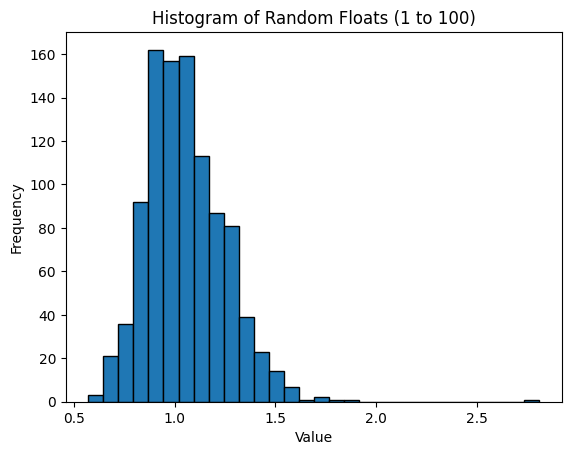

In [11]:
data = result_content_rate  # 1000 random floats between 1 and 100

# Plot histogram
plt.hist(data, bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Random Floats (1 to 100)')
plt.show()